# Wordle

This is a fun project aimed to optimise finding the Wordle.

---
We adopt the following strategy:

1. start with an optimised initial guess. Here we use the following strategy
   * given the complete collection of English words (from nltk.corpus import words), restrict to 5-letter words
   * look for characters that occur most frequently (they would have the highest probabilities to occur in the actual wordle as well)
   * use these characters to form the best optimised first guess
  
2. before the next guess:
   * greys are eliminated from the list of alphabets
   * greens are held fixed in position for the next guess
   * oranges are kept making sure they occur in a different position, not already held by a green

3. repeat step 2.
---

In [1]:
import nltk
import pandas as pd
import regex as re
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rcParams['axes.linewidth'] = 1.
mpl.rcParams['axes.labelsize'] = 20.
mpl.rcParams['axes.titlesize'] = 14.
#mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['xtick.labelsize']= 14.
mpl.rcParams['ytick.labelsize']= 14.
mpl.rcParams['xtick.major.size']= 14.
mpl.rcParams['xtick.minor.size']= 1.5
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.major.size']= 14.
mpl.rcParams['ytick.minor.size']= 2.5
mpl.rcParams['ytick.direction'] = 'in' 
mpl.rcParams['lines.markersize']= 8
mpl.rcParams['lines.markeredgewidth']=2
mpl.rcParams['ytick.minor.size']= 3.
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.markerscale'] = 0.5
mpl.rcParams['legend.framealpha']=0.
mpl.rcParams['legend.borderaxespad']=4.0
mpl.rcParams['legend.handletextpad']=0.5
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'stixsans'

# List of words

In [3]:
from nltk.corpus import words

In [4]:
#allwords = words.words()
allwords = np.genfromtxt("./words_alpha.txt", dtype='str')
print("Total number of words in the corpus: ", len(allwords))

Total number of words in the corpus:  370103


# List of 5-letter words

In [5]:
flcn = [word for word in allwords if len(word) == 5 and word.islower()]
print("Total number of 5-lettered words: ", len(flcn))

Total number of 5-lettered words:  15918


In [6]:
for word in [''.join(flcn)]:
    res = {i : word.count(i) for i in set(word)}
    
df = pd.Series(res)

In [7]:
#df.head()

# Frequency of characters
in the list of 5-letter words

<AxesSubplot:xlabel='Alphabets', ylabel='Counts'>

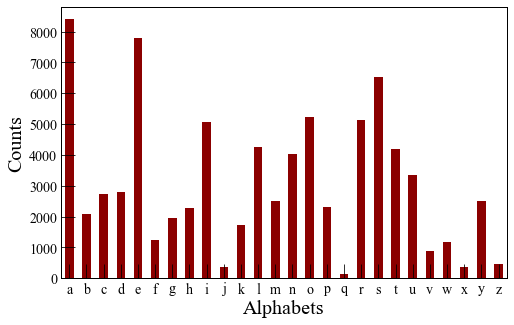

In [8]:
df.sort_index().plot.bar(color='darkred', xlabel='Alphabets', ylabel='Counts', figsize=(8,5), rot=0)

In [9]:
sorted(df.sort_values()[-5:].keys())

['a', 'e', 'o', 'r', 's']

In [10]:
x = [word for word in flcn if sorted(word) == ['a', 'e', 'i', 'o', 'r']]
x

[]

---
The 5 most commonly occuring characters in our corpus are ['a', 'e', 'i', 'o', 'r']. However, we can't make a meaningful 5-letter word from them. So we move over to the next most commonly occuring letter.

---

In [11]:
sorted(df.sort_values()[-6:].keys())

['a', 'e', 'i', 'o', 'r', 's']

---
**Assumption:**  We make a choice here to use 't' in place of the least occuring vowel from the above list, to strike a balance between vowels and consonents.

---

# First Guess

In [12]:
x = [word for word in flcn if sorted(word) == ['a', 'e', 'i', 'r', 't']]
x

['arite', 'artie', 'irate', 'retia', 'tarie', 'terai']

---
Here, we can use any of the above four words as our first guess. We choose **'irate'**.


**First Guess: 'irate'**

<img src="./" alt="drawing" width="400"/>

---

# Subsequent Guesses

Now, we follow the general strategy:
* eliminate greys
* fix greens
* shuffle oranges

In [13]:
# function to return a list of most-probable guesses
# given an eligible list of words and letters
# and provided information about greys, greens and oranges

def guess_maker(greys, greens, oranges, df_remaining_letters, word_list_remaining):
    
    print("#"*100)
    print(f"Number of (intial) eligible words: {len(word_list_remaining)}")
    print(f"Number of (intial) eligible letters: {len(df_remaining_letters.keys())}, {df_remaining_letters.keys()}")
    
    # drop greys and merge the remaining characters for a generic match pattern
    df = df_remaining_letters.drop(greys)
    x = "".join(df.keys())
    
    # generic match pattern (we take the approach of matching the most general word 
    # and then filtering the list based on sesequent conditions)
    match_pattern = f'^[{x}][{x}][{x}][{x}][{x}]$'
    
    # reduced list of words without greys
    word_list_grey = [word for word in word_list_remaining if re.match(match_pattern, word)]
    print(f"Number of words without greys, {greys}: {len(word_list_grey)}")
    
    
    # reduce word list accorinding to the fixed green positions
    word_list_green = word_list_grey # initialise
    for key in greens.keys():
        word_list_green = [word for word in word_list_green if word[greens[key]] == key]
        print(f"Number of remaining words with green {key} in position {greens[key]}: {len(word_list_green)}")
    
    # finally, incorporate the oranges in a copule of steps
    word_list_orange = word_list_green # initialise
    for key in oranges.keys():

        # make sure oranges appear atleast once...
        word_list_orange = [word for word in word_list_orange if re.search(key, word)]

        # ... and don't appear in their previous positions
        for pos in range(len(oranges[key])):
            word_list_orange = [word for word in word_list_orange if word[oranges[key][pos]] != key]
            print(f"Number of remaining words after orange operation for {key} in position {oranges[key][pos]}: {len(word_list_orange)}")
                    
    word_list_red = word_list_orange
    
    # update the frequency of characters in the remaining words
    for word in [''.join(word_list_red)]:
        res = {i : word.count(i) for i in set(word)}
    
    df = pd.Series(res)
    
    # and plot their distribution
    df.sort_index().plot.bar(color='darkred', xlabel='Alphabets', ylabel='Counts', figsize=(8,5), rot=0)
    
    print("Remaining letters (in decreasing order of frequency): ", len(df.sort_values()[::-1].keys()), df.sort_values()[::-1].keys())
    
    # Best guesses
    
    # The while loop iterates through the most frequently occuring letters
    # remaining in the list of alphabets
    tol = 4
    while tol <= len(df):
        match_string = "".join(df.sort_values()[-tol:].keys())
        match_pattern = f'^[{match_string}][{match_string}][{match_string}][{match_string}][{match_string}]$'

        guess_list = [word for word in word_list_red if re.match(match_pattern, word) != None and len(list(set(word))) >= 4]
        
        # to most optimise our guess, we restrict to words where same letter does not appear
        # more than once in the word
        
        if not guess_list:
            print(f"Guess list is empty at tolerance {-tol}")
        else:
            break
        tol += 1
    
    print("-"*100)
    print("Best guesses: ", guess_list)
    print("-"*100)
            
    return df, word_list_red

## Second guess

####################################################################################################
Number of (intial) eligible words: 15918
Number of (intial) eligible letters: 26, Index(['o', 'f', 'x', 'd', 'g', 'a', 'b', 't', 's', 'p', 'r', 'i', 'e', 'k',
       'v', 'u', 'z', 'm', 'h', 'w', 'y', 'l', 'j', 'q', 'n', 'c'],
      dtype='object')
Number of words without greys, ['a', 'e', 't']: 3045
Number of remaining words with green r in position 1: 245
Number of remaining words after orange operation for i in position 0: 87
Remaining letters (in decreasing order of frequency):  20 Index(['i', 'r', 's', 'p', 'b', 'c', 'g', 'o', 'n', 'd', 'l', 'k', 'm', 'u',
       'y', 'f', 'z', 'v', 'h', 'w'],
      dtype='object')
----------------------------------------------------------------------------------------------------
Best guesses:  ['priss']
----------------------------------------------------------------------------------------------------


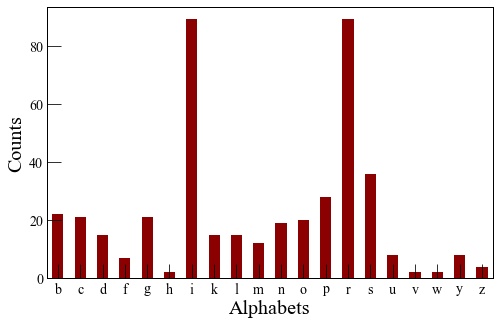

In [14]:
greys = ['a', 'e', 't']
greens = {'r': 1}
oranges = {'i': [0]}

df2, flcn2 = guess_maker(greys, greens, oranges, df, flcn)

---
**Second Guess: 'priss'**

<img src="./guess2.png" alt="drawing" width="400"/>

---

## Third Guess

####################################################################################################
Number of (intial) eligible words: 87
Number of (intial) eligible letters: 20, Index(['o', 'f', 'g', 'd', 'b', 's', 'p', 'r', 'i', 'k', 'v', 'z', 'u', 'm',
       'h', 'w', 'y', 'l', 'n', 'c'],
      dtype='object')
Number of words without greys, ['s', 'p']: 38
Number of remaining words with green i in position 2: 26
Remaining letters (in decreasing order of frequency):  17 Index(['i', 'r', 'l', 'n', 'b', 'k', 'g', 'c', 'd', 'z', 'f', 'o', 'm', 'y',
       'w', 'u', 'v'],
      dtype='object')
Guess list is empty at tolerance -4
----------------------------------------------------------------------------------------------------
Best guesses:  ['brill']
----------------------------------------------------------------------------------------------------


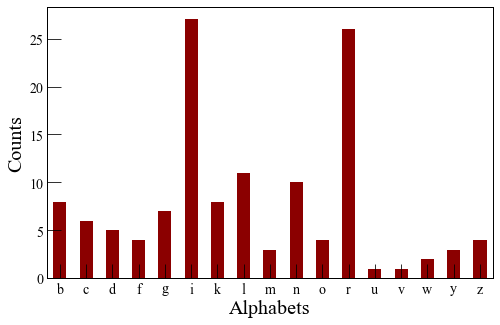

In [15]:
greys = ['s', 'p']
greens = {'i': 2}
oranges = {}

df3, flcn3 = guess_maker(greys, greens, oranges, df2, flcn2)

---
**Second Guess: 'brill'**

<img src="./guess3.png" alt="drawing" width="400"/>

---

## Fourth Guess

####################################################################################################
Number of (intial) eligible words: 26
Number of (intial) eligible letters: 17, Index(['i', 'k', 'l', 'o', 'f', 'v', 'z', 'u', 'n', 'g', 'd', 'm', 'r', 'b',
       'w', 'y', 'c'],
      dtype='object')
Number of words without greys, ['l']: 20
Number of remaining words after orange operation for k in position 0: 6
Remaining letters (in decreasing order of frequency):  8 Index(['r', 'k', 'i', 'c', 'n', 'b', 'w', 'd'], dtype='object')
----------------------------------------------------------------------------------------------------
Best guesses:  ['crick']
----------------------------------------------------------------------------------------------------


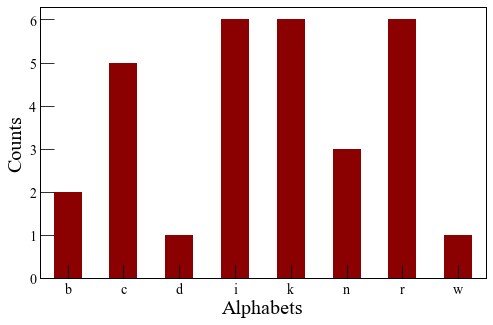

In [16]:
greys = ['l']
greens = {}
oranges = {'k': [0]}

df4, flcn4 = guess_maker(greys, greens, oranges, df3, flcn3)

---
**Fourth Guess: 'crick'**

<img src="./guess4.png" alt="drawing" width="400"/>

---

## Fifth Guess

####################################################################################################
Number of (intial) eligible words: 6
Number of (intial) eligible letters: 8, Index(['i', 'k', 'n', 'd', 'r', 'b', 'w', 'c'], dtype='object')
Number of words without greys, ['c']: 2
Number of remaining words with green k in position 4: 2
Remaining letters (in decreasing order of frequency):  6 Index(['r', 'n', 'k', 'i', 'b', 'd'], dtype='object')
Guess list is empty at tolerance -4
----------------------------------------------------------------------------------------------------
Best guesses:  ['brink']
----------------------------------------------------------------------------------------------------


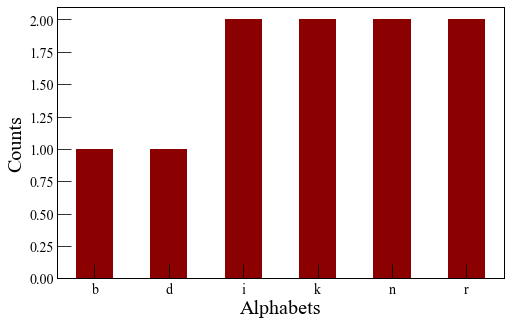

In [17]:
greys = ['c']
greens = {'k': 4}
oranges = {}

df5, flcn5 = guess_maker(greys, greens, oranges, df4, flcn4)

---
**Fifth Guess: 'brink'**

<img src="./guess5.png" alt="drawing" width="400"/>

---

# Last Guess

####################################################################################################
Number of (intial) eligible words: 2
Number of (intial) eligible letters: 6, Index(['i', 'k', 'n', 'd', 'r', 'b'], dtype='object')
Number of words without greys, ['b']: 1
Number of remaining words with green n in position 3: 1
Remaining letters (in decreasing order of frequency):  5 Index(['r', 'n', 'd', 'k', 'i'], dtype='object')
Guess list is empty at tolerance -4
----------------------------------------------------------------------------------------------------
Best guesses:  ['drink']
----------------------------------------------------------------------------------------------------
All remaining words:  ['drink']


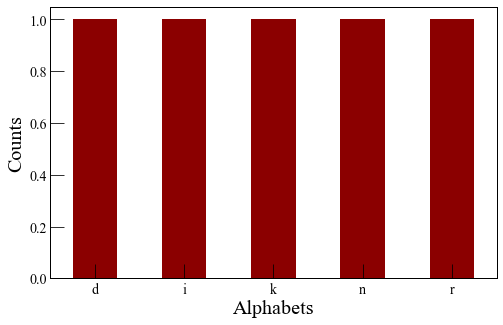

In [18]:
greys = ['b']
greens = {'n': 3}
oranges = {}

df6, flcn6 = guess_maker(greys, greens, oranges, df5, flcn5)
print("All remaining words: ", flcn6)

---
**Last Guess: 'drink'**

<img src="./guess6.png" alt="drawing" width="400"/>

---

# Plots outlining the above data analysis technique

## How the relative importance of each letter change after each guess?

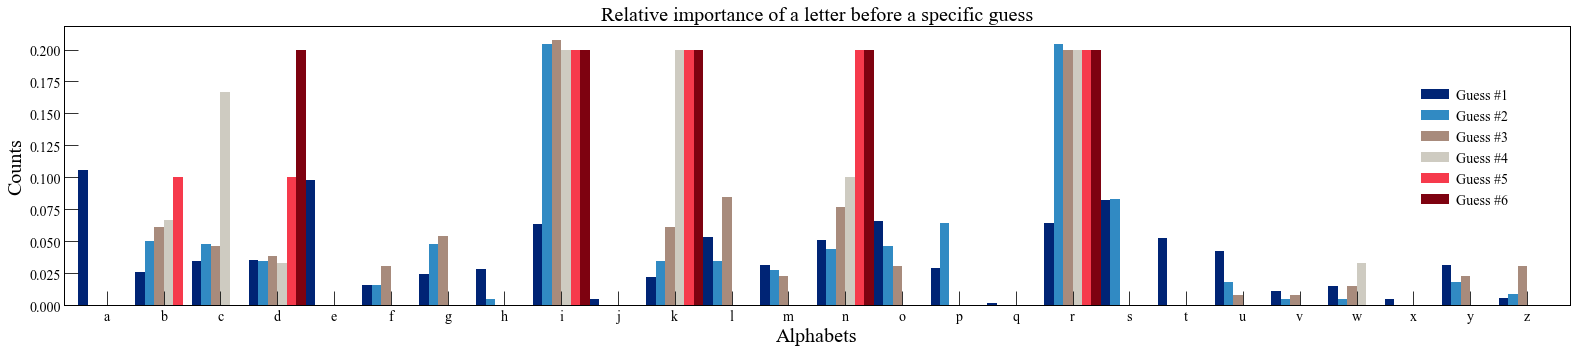

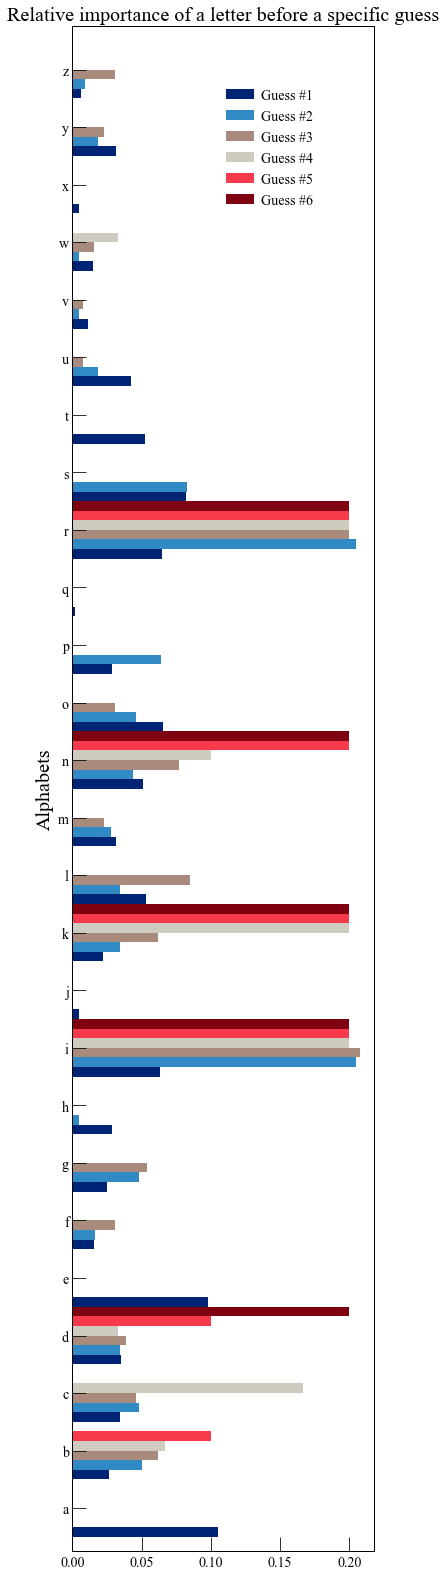

In [19]:
dfn = {'df0': df,
       'df1': df2, 
       'df2': df3,
       'df3': df4,
       'df4': df5,
       'df5': df6}

dfn = pd.concat(dfn,
               axis = 1)

dfn.fillna(0, inplace=True)

col_names = [f"df{n}" for n in range(6)]

for col in col_names:
    dfn[col] = dfn[col]/dfn[col].sum()
    
color_list = ["#002475", "#318ac3", "#a88b7c", "#cecbc1", "#f63a4c", "#7e0210"]

color_dict = dict(zip(col_names, color_list))

dfn.sort_index().plot.bar(color=color_dict, 
                          xlabel='Alphabets', ylabel='Counts', figsize=(22,5), rot=0,
                         width=1)

plt.legend(["Guess #1", "Guess #2", "Guess #3", "Guess #4", "Guess #5", "Guess #6"], loc='upper right')
plt.title("Relative importance of a letter before a specific guess", fontsize=20)
plt.tight_layout()

dfn.sort_index().plot.barh(color=color_dict, 
                          xlabel='Alphabets', ylabel='Counts', figsize=(5,22), rot=0,
                         width=1)

plt.legend(["Guess #1", "Guess #2", "Guess #3", "Guess #4", "Guess #5", "Guess #6"], loc='upper right')
plt.title("Relative importance of a letter before a specific guess", fontsize=20)
plt.tight_layout()